<a href="https://colab.research.google.com/github/giulialuongo90/speech-recognition/blob/main/speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech recognition

In [ ]:
path_folder = '/gdrive/MyDrive/numpy'

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras as K
import matplotlib.pyplot as plt

## Build the dataset

In [ ]:
filenames = ['bed.npy', 'eight.npy', 'house.npy', 'off.npy', 'sheila.npy',
             'two.npy', 'bird.npy', 'five.npy', 'left.npy', 'one.npy', 'six.npy',
             'up.npy', 'cat.npy', 'four.npy', 'marvel.npy', 'on.npy', 'stop.npy',
             'wow.npy', 'dog.npy', 'go.npy', 'nine.npy', 'right.npy', 'three.npy',
             'yes.npy', 'down.npy', 'happy.npy', 'no.npy', 'seven.npy', 'tree.npy', 'zero.npy']

x = []
y = []
for target_id, f in enumerate(filenames):
    data = np.load(os.path.join(path_folder, f))
    targets = tf.ones(data.shape[0], dtype=tf.int32) * target_id
    x.append(data)
    y.append(targets)

In [ ]:
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)
print(x.shape, y.shape)

(41849, 101, 40) (41849,)


In [ ]:
batch_size = x.shape[0]
sequence_length = x.shape[1]
input_size = x.shape[2]

print('Batch size:',batch_size)
print('Sequence length:',sequence_length)
print('Input size:', input_size)

Batch size: 41849
Sequence length: 101
Input size: 40


In [ ]:
num_classes = len(np.unique(y))
print('Num classes:', num_classes)

Num classes: 30


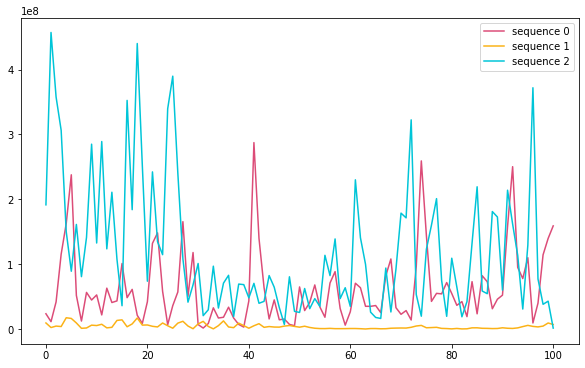

In [ ]:
# plot first 3 sequences, first feature
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, sequence_length), x[0, : , 0], color='#DC4C78', label="sequence 0")
plt.plot(np.arange(0, sequence_length), x[1, : , 0], color='#FBB216', label="sequence 1")
plt.plot(np.arange(0, sequence_length), x[2, : , 0], color='#00C5D8', label="sequence 2")
plt.legend(loc="best")
plt.show()

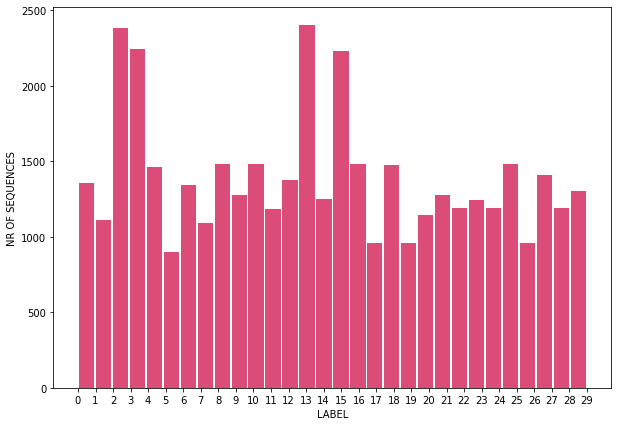

In [ ]:
# plot data distribution per class

plt.figure(figsize=(10,7))
plt.hist(y, color='#DC4C78', bins=30, rwidth=0.9)
plt.xlabel('LABEL')
plt.ylabel('NR OF SEQUENCES')
plt.xticks(np.arange(0,30,step=1))
plt.show()

In [ ]:
import pandas as pd

classes = pd.DataFrame(columns=['LABEL','NR OF SEQUENCES'], index=range(30))

for el in y:
  classes.at[el, 'LABEL'] = el
  classes.at[el, 'NR OF SEQUENCES'] = np.count_nonzero(y == el)

In [ ]:
classes.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
LABEL,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
NR OF SEQUENCES,1356,1113,2382,2244,1463,902,1346,1092,1485,1276,...,1144,1276,1188,1244,1188,1481,957,1411,1188,1306


## Train/Test/Validation Split



In [ ]:
from sklearn.model_selection import train_test_split

Train / Test

In [ ]:
test_size = int(0.25 * y.shape[0])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True, stratify=y)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((31387, 101, 40), (31387,), (10462, 101, 40), (10462,))

Train / Validation

In [ ]:
test_size=int(0.20*y_train.shape[0])
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=test_size, shuffle=True, stratify=y_train)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((25110, 101, 40), (25110,), (6277, 101, 40), (6277,))

## Normalization

In [ ]:
from tensorflow.keras.layers import Normalization

In [ ]:
norm_layer = Normalization(axis=-1)
norm_layer.adapt(x_train)
normalized_x_train = norm_layer(x_train)
normalized_x_valid = norm_layer(x_valid)
normalized_x_test = norm_layer(x_test)

In [ ]:
print("Training data")
print("Mean: ", np.mean(normalized_x_train))
print("Std: ", np.std(normalized_x_train))

Training data
Mean:  1.4876674e-08
Std:  1.0000006


In [ ]:
print("Test data")
print("Mean: ", np.mean(normalized_x_test))
print("Std: ", np.std(normalized_x_test))

Test data
Mean:  -0.005306041
Std:  0.9835531


In [ ]:
print("Validation data")
print("Mean: ", np.mean(normalized_x_valid))
print("Std: ", np.std(normalized_x_valid))

Validation data
Mean:  -0.0014269846
Std:  0.9840288


## MLP

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def get_compiled_model_MLP(n1,n2):
  model = K.Sequential()
  model.add(K.layers.Input(shape=(sequence_length, input_size)))
  model.add(K.layers.Reshape((sequence_length*input_size,)))
  model.add(K.layers.Dense(n1, activation="tanh"))
  model.add(K.layers.Dense(n2, activation="tanh"))
  model.add(K.layers.Dense(n2, activation="tanh"))
  model.add(K.layers.Dense(num_classes, activation="softmax"))
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
# GRID SEARCH

choices = {"bs": [16,32,64], "n1":[32,64,128], "n2":[32,64,128]}
grid = ParameterGrid(choices)
print(len(list(grid)))

27


In [ ]:
best_loss = 100000
best_conf = None
for el in grid:
  print()
  print("Training with configuration:  ", "batch size- ", el["bs"],", neuroni-" , el["n1"], el["n2"] )
  model = get_compiled_model_MLP(el["n1"], el["n2"])
  model.fit(normalized_x_train, y_train, epochs=10, batch_size=el["bs"], verbose=0)
  metrics = model.evaluate(normalized_x_valid, y_valid)
  loss = metrics[0]
  accuracy = metrics[1]
  print('Validation')
  print("Loss: ", loss)
  print("Accuracy: ", accuracy)
  if loss < best_loss:
    print("Found better configuration")
    best_loss = loss
    best_conf = el

print('BEST LOSS: ', best_loss)
print('BEST CONF: ', best_conf)


Training with configuration:   batch size-  16 , neuroni- 32 32
197/197 [==============================] - 1s 2ms/step - loss: 0.4223 - accuracy: 0.8775
Validation
Loss:  0.42230042815208435
Accuracy:  0.8774892687797546
Found better configuration

Training with configuration:   batch size-  16 , neuroni- 32 64
197/197 [==============================] - 1s 2ms/step - loss: 0.3983 - accuracy: 0.8880
Validation
Loss:  0.3983222246170044
Accuracy:  0.8880038261413574
Found better configuration

Training with configuration:   batch size-  16 , neuroni- 32 128
197/197 [==============================] - 1s 2ms/step - loss: 0.4167 - accuracy: 0.8864
Validation
Loss:  0.4166521430015564
Accuracy:  0.8864107131958008

Training with configuration:   batch size-  16 , neuroni- 64 32
197/197 [==============================] - 1s 2ms/step - loss: 0.3844 - accuracy: 0.8885
Validation
Loss:  0.3843748867511749
Accuracy:  0.8884817361831665
Found better configuration

Training with configuration:   b

### Model

In [ ]:
model = K.Sequential()
model.add(K.layers.Input(shape=(sequence_length, input_size)))
model.add(K.layers.Reshape((sequence_length*input_size,)))
model.add(K.layers.Dense(64, activation="tanh"))
model.add(K.layers.Dense(128, activation="tanh"))
model.add(K.layers.Dense(128, activation="tanh"))
model.add(K.layers.Dense(num_classes, activation="softmax"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

history = model.fit(normalized_x_train, y_train, epochs=20, batch_size=64, validation_data=(normalized_x_valid, y_valid))

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_53 (Reshape)        (None, 4040)              0         
                                                                 
 dense_238 (Dense)           (None, 64)                258624    
                                                                 
 dense_239 (Dense)           (None, 128)               8320      
                                                                 
 dense_240 (Dense)           (None, 128)               16512     
                                                                 
 dense_241 (Dense)           (None, 30)                3870      
                                                                 
Total params: 287,326
Trainable params: 287,326
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
393/393 [======================

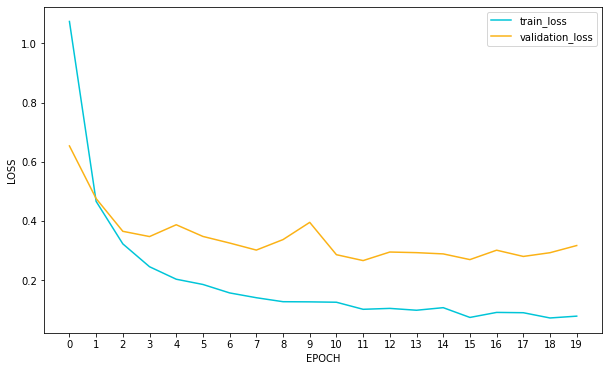

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],  label='train_loss', color='#00C5D8')
plt.plot(history.history['val_loss'], label='validation_loss', color='#FBB216')
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.xticks(ticks=np.arange(0, 20, step=1))
plt.legend(loc='best')
plt.show()

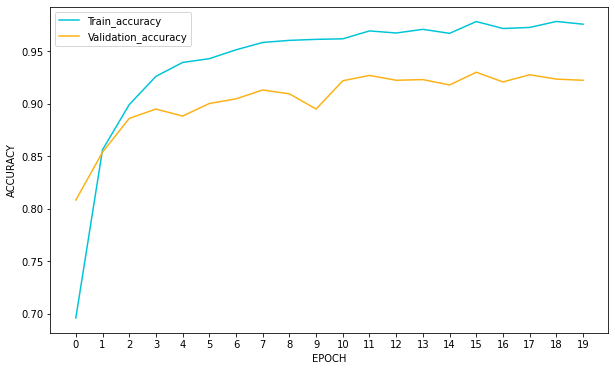

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train_accuracy', color='#00C5D8')
plt.plot(history.history['val_accuracy'], label='Validation_accuracy', color='#FBB216')
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY")
plt.xticks(ticks=np.arange(0, 20, step=1))
plt.legend(loc='best')
plt.show()

In [ ]:
metrics = model.evaluate(normalized_x_test, y_test)
metrics

327/327 [==============================] - 1s 2ms/step - loss: 0.3252 - accuracy: 0.9187


[0.32523807883262634, 0.9186580181121826]

## CNN

### Hyperparameter tuning

In [ ]:
def get_compiled_model_CNN(k):
  inputs = K.layers.Input((sequence_length, input_size))

  conv1 = K.layers.Conv1D(filters=16, kernel_size=k, padding="same")(inputs)
  conv1 = K.layers.ReLU()(conv1)

  conv2 = K.layers.Conv1D(filters=32, kernel_size=k, padding="same")(conv1)
  conv2 = K.layers.ReLU()(conv2)

  conv3 = K.layers.Conv1D(filters=64, kernel_size=k, padding="same")(conv2)
  conv3 = K.layers.ReLU()(conv3)

  final = K.layers.GlobalAveragePooling1D()(conv3)
  outputs = K.layers.Dense(num_classes, activation="softmax")(final)

  model = K.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model


In [ ]:
choices = {"ep": [10,15,20], "bs": [4,8,16,32], "k":[2,4]}
grid = ParameterGrid(choices)
print(len(list(grid)))

24


In [ ]:
best_loss = 100000
best_conf = None
for el in grid:
  print()
  print("Training with configuration:  epochs-",el["ep"], "batch size- ", el["bs"],", kernel-" , el["k"] )
  model = get_compiled_model_CNN(el["k"])
  model.fit(normalized_x_train, y_train, epochs=el["ep"], batch_size=el["bs"], verbose=0)
  metrics = model.evaluate(normalized_x_valid, y_valid)
  loss = metrics[0]
  accuracy = metrics[1]
  print('Validation')
  print("Loss: ", loss)
  print("Accuracy: ", accuracy)
  if loss < best_loss:
    print("Found better configuration")
    best_loss = loss
    best_conf = el
print('BEST LOSS: ', best_loss)
print('BEST CONF: ', best_conf)


Training with configuration:  epochs- 10 batch size-  4 , kernel- 2
197/197 [==============================] - 1s 5ms/step - loss: 0.1968 - accuracy: 0.9516
Validation
Loss:  0.1968243420124054
Accuracy:  0.9515691995620728
Found better configuration

Training with configuration:  epochs- 10 batch size-  4 , kernel- 4
197/197 [==============================] - 1s 7ms/step - loss: 0.1210 - accuracy: 0.9681
Validation
Loss:  0.12102121114730835
Accuracy:  0.9681376218795776
Found better configuration

Training with configuration:  epochs- 15 batch size-  4 , kernel- 2
197/197 [==============================] - 1s 6ms/step - loss: 0.1498 - accuracy: 0.9648
Validation
Loss:  0.14982903003692627
Accuracy:  0.9647920727729797

Training with configuration:  epochs- 15 batch size-  4 , kernel- 4
197/197 [==============================] - 1s 6ms/step - loss: 0.2719 - accuracy: 0.9587
Validation
Loss:  0.2718907296657562
Accuracy:  0.9587382674217224

Training with configuration:  epochs- 20 ba

### Model

In [ ]:
inputs = K.layers.Input((sequence_length, input_size))

conv1 = K.layers.Conv1D(filters=16, kernel_size=4, padding="same")(inputs)
conv1 = K.layers.ReLU()(conv1)

conv2 = K.layers.Conv1D(filters=32, kernel_size=4, padding="same")(conv1)
conv2 = K.layers.ReLU()(conv2)

conv3 = K.layers.Conv1D(filters=64, kernel_size=4, padding="same")(conv2)
conv3 = K.layers.ReLU()(conv3)

final = K.layers.GlobalAveragePooling1D()(conv3)
outputs = K.layers.Dense(num_classes, activation="softmax")(final)

model = K.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

history = model.fit(normalized_x_train, y_train, epochs=20, batch_size=4, validation_data=(normalized_x_valid, y_valid))

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 101, 40)]         0         
                                                                 
 conv1d_75 (Conv1D)          (None, 101, 16)           2576      
                                                                 
 re_lu_75 (ReLU)             (None, 101, 16)           0         
                                                                 
 conv1d_76 (Conv1D)          (None, 101, 32)           2080      
                                                                 
 re_lu_76 (ReLU)             (None, 101, 32)           0         
                                                                 
 conv1d_77 (Conv1D)          (None, 101, 64)           8256      
                                                                 
 re_lu_77 (ReLU)             (None, 101, 64)           0  

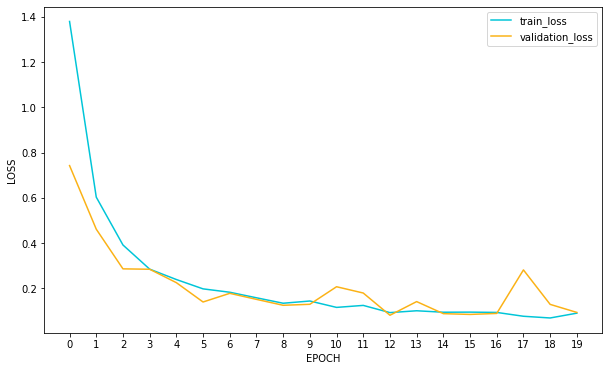

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],  label='train_loss', color='#00C5D8')
plt.plot(history.history['val_loss'], label='validation_loss', color='#FBB216')
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.xticks(ticks=np.arange(0, 20, step=1))
plt.legend(loc='best')
plt.show()

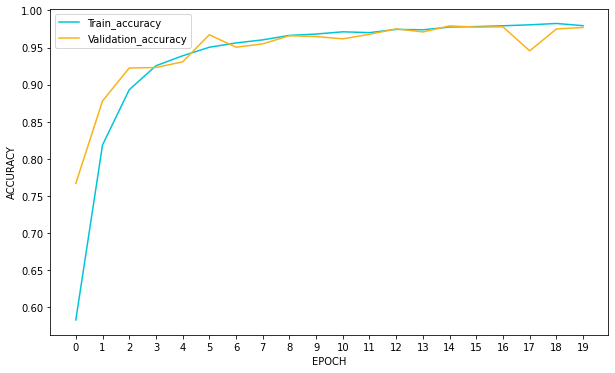

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train_accuracy', color='#00C5D8')
plt.plot(history.history['val_accuracy'], label='Validation_accuracy', color='#FBB216')
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY")
plt.xticks(ticks=np.arange(0, 20, step=1))
plt.legend(loc='best')
plt.show()

In [ ]:
metrics = model.evaluate(normalized_x_test, y_test)
metrics

327/327 [==============================] - 2s 7ms/step - loss: 0.1106 - accuracy: 0.9775


[0.11055858433246613, 0.9775377511978149]